In [2]:
    import tensorflow as tf
    from tensorflow import keras

2025-07-14 18:09:12.265538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 18:09:12.307710: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:09:12.636551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 18:09:12.922204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752534553.185700    7265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752534553.25

In [ ]:
To do:
Implement test set
augment data
potentially try to increase complexity of data
show example of augment photos as well as non augmented
commenting
I got a lot of work to do ngl
try using as little images as possible, due to how data is loading, police cars are causing some problems with this

In [3]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [ ]:
# Was checking if path was correct need to run cell before first
print(os.path.exists(civilian_folder))  


In [4]:
#Have to use /mnt/c/ beacuse i am working through ubuntu
civilian_folder = '/mnt/c/Users/smith/Downloads/Vehicle Classification.v2i.folder/train/car'
civilian_target = 'Police_Car/data/civilian'

os.makedirs(civilian_target, exist_ok=True)

# List all images
all_images = [f for f in os.listdir(civilian_folder) if f.lower().endswith(('.jpg', '.png'))]

# Randomly sample n images
n=100
sampled_images = random.sample(all_images, n)

# Copy to target folder
for img_name in sampled_images:
    shutil.copy(os.path.join(civilian_folder, img_name), os.path.join(civilian_target, img_name))

In [5]:
print(f"Total police images found: {len(all_images)}")

Total police images found: 4692


In [8]:
police_folder = '/mnt/c/Users/smith/Downloads/police_cars.v1i.folder/train'
police_target = 'Police_Car/data/police'

os.makedirs(police_target, exist_ok=True)

for img_name in os.listdir(police_folder):
    if img_name.lower().endswith(('.jpg', '.png')):
        shutil.copy(os.path.join(police_folder, img_name), os.path.join(police_target, img_name))





In [9]:
data_dir = 'Police_Car/data' 

#splitting data set
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

#basic augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load training images
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Load validation images
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 2160 images belonging to 2 classes.
Found 539 images belonging to 2 classes.


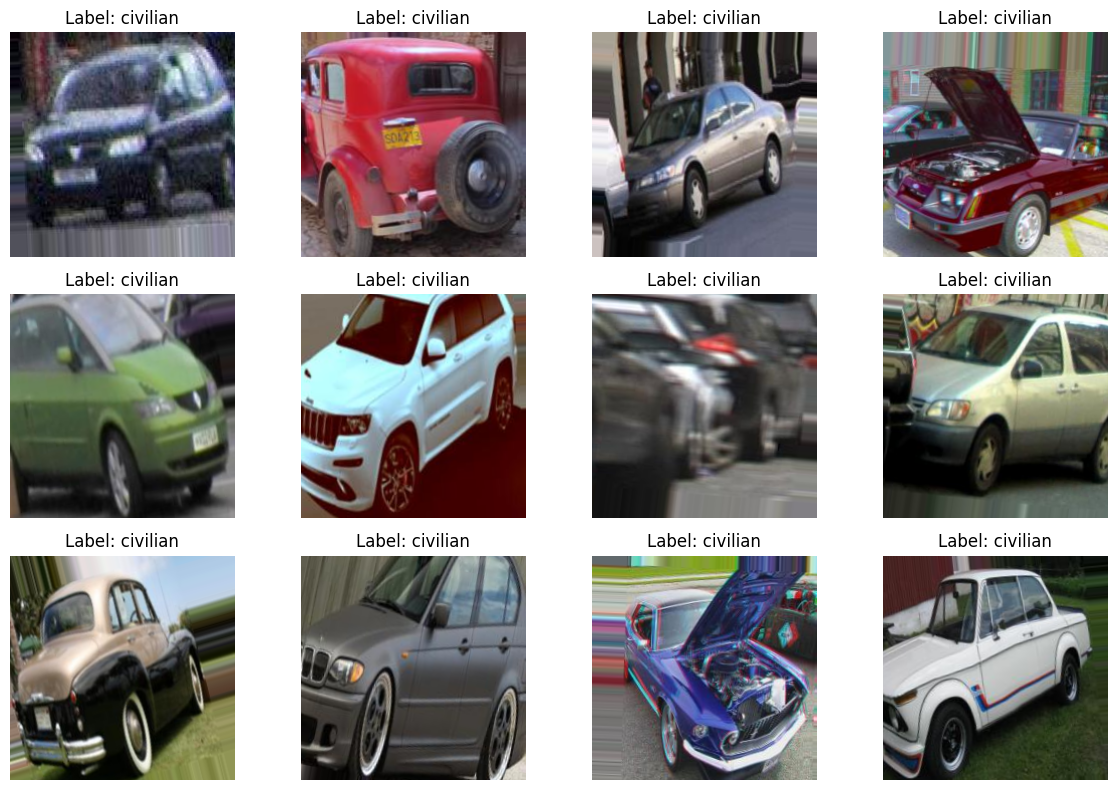

In [15]:
#looking at civilan cars

# Get class labels
class_labels = list(train_data.class_indices.keys())

images, labels = next(train_data)

plt.figure(figsize=(12, 8))

for i in range(12):
    plt.subplot(3, 4, i+1)
    img = images[i]
    label = int(labels[i])
    
    plt.imshow(img)
    plt.title(f"Label: {class_labels[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
# resnet 50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to start with
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# Trying out early stopping because why not, will customize later
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=3,              
    restore_best_weights=True
)

# Train the model after small bit of optimization, will customize more later
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop] 
)



2025-07-14 18:12:31.839092: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/smithb23/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7868 - loss: 0.3778

/home/smithb23/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7891 - loss: 0.3748 - val_accuracy: 1.0000 - val_loss: 0.0256
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 9.8212e-04
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 1.0000 - loss: 8.3905e-04 - val_accuracy: 1.0000 - val_

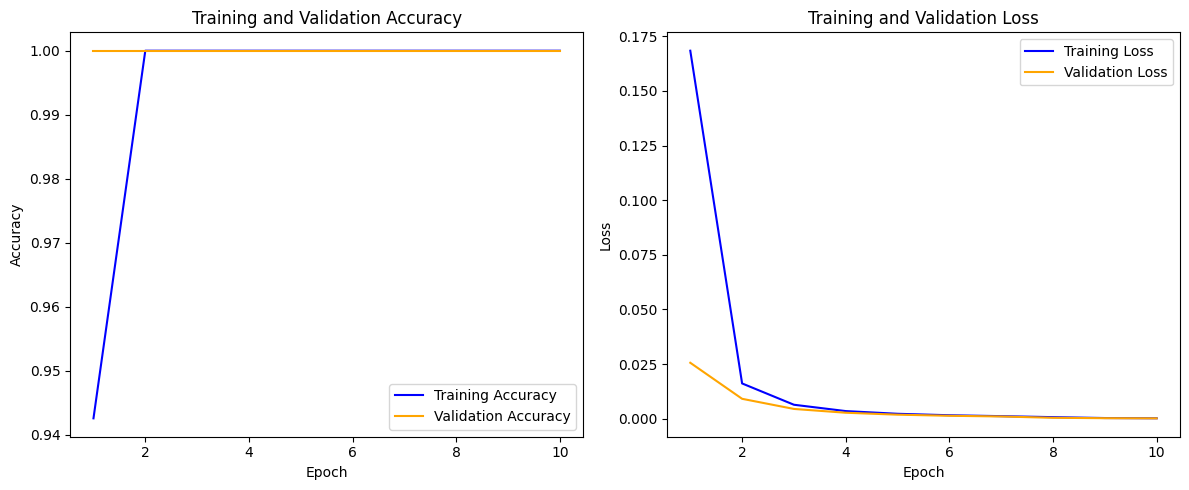

In [14]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#When using 400 civilian car images, the accuracy and validation was 100% before augmentation
#When using 1000 civilian car images, the accuracy and validation was 100% before augmentation after 1 epoch
